In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import functions2d as fun

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

In [2]:
which = 'laplace'
# options available: 

### Differential equation: 


In [3]:
diff_eq = fun.diff_eq[which]
degree = fun.degree[which]

### Real function:


In [4]:
real = fun.function[which]

### Trial function:

In [5]:
trial = fun.trial[which]

Function needed to perform the training

In [6]:
def g(t, nn):
    t1 = t[:, 0]
    t2 = t[:, 1]
    x = trial(nn, t1, t2).view(-1)
    gx = []
    gradx = []
    gradx.append(grad([x], [t1], grad_outputs=torch.ones(t1.shape), create_graph=True)[0])
    gradx.append(grad([x], [t2], grad_outputs=torch.ones(t2.shape), create_graph=True)[0])
    
    gx.append(gradx)
    if degree > 1:
        grad2x = []
        grad2x.append(grad([gradx[0]], [t1], grad_outputs=torch.ones(t1.shape), create_graph=True)[0])
        grad2x.append(grad([gradx[1]], [t2], grad_outputs=torch.ones(t2.shape), create_graph=True)[0])

        gx.append(grad2x)
    z = diff_eq(t, x, gx)
    return z

Define:
* range of the function;
* the number of training points;
* neural network parameters (input, hidden neurons and output)

In [7]:
x1_min, x1_max, x2_min, x2_max = fun.interval[which]

n_train = 16

D_in, H, D_out = 2, 10, 1

### Training data: 
(unsupervised, no labels)

In [8]:
x1_train = np.linspace(x1_min, x1_max, n_train)
x2_train = np.linspace(x2_min, x2_max, n_train)
X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x = Variable(torch.cat((torch.Tensor(X1_train).view(-1, 1), torch.Tensor(X2_train).view(-1, 1)), 1), requires_grad=True)

Define: 
* the neural network architecture (1 hiddel layer, fully connected, LogSigmoid as activation)
* the loss function (MSE, L1, ...)
* the optimizer (Adam, LBFGS, ...)
* the scheduler to change the learning rate

In [9]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    #torch.nn.Sigmoid(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

criterion = torch.nn.MSELoss(size_average=False)
#criterion = torch.nn.L1Loss(size_average=False)


#optimizer = optim.Adam(seq.parameters(), lr=1e-1)
optimizer = optim.LBFGS(seq.parameters(), lr=1e-1)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

### Train the network

In [10]:
n_epoch = 100
Loss = []
for t in tqdm(range(n_epoch)): 
    y = g(x, seq)
    loss = criterion(y, torch.zeros(y.shape))
    optimizer.zero_grad()
    loss.backward()
    #optimizer.step()
    def closure():
        y = g(x, seq)
        loss = criterion(y, torch.zeros(y.shape))        
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)
    #scheduler.step()
    Loss.append(loss.data.numpy())

100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


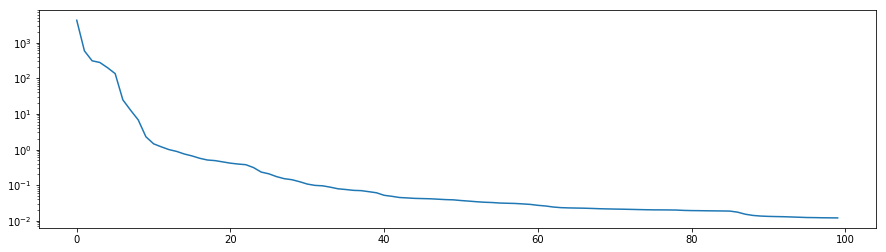

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(Loss)
plt.yscale('log')
plt.show()

### Test data:

In [12]:
n_test = 100
x1_min_test, x1_max_test, x2_min_test, x2_max_test = fun.interval[which]

x1_test = np.linspace(x1_min_test, x1_max_test, n_test)
x2_test = np.linspace(x2_min_test, x2_max_test, n_test)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
x_test = Variable(torch.cat((torch.Tensor(X1_test).view(-1, 1), torch.Tensor(X2_test).view(-1, 1)), 1))

y_pred = trial(seq, x_test[:, 0], x_test[:, 1]).view(X1_test.shape)
y_real = real(x_test).view(X1_test.shape)

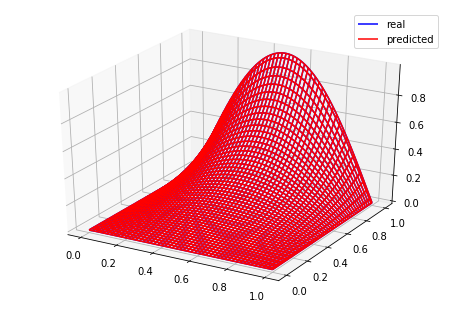

In [13]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X1_test, X2_test, y_real.data.numpy(), color='b', label='real')
ax.plot_wireframe(X1_test, X2_test, y_pred.data.numpy(), color='r', label='predicted')
plt.legend(loc='best')

plt.show()

### Error:
$$error = |y_{real} - y_{predicted}|$$

In [14]:
diff = abs(y_real-y_pred)

In [15]:
#fig = plt.figure()
#ax = Axes3D(fig)
#ax.plot_wireframe(X1_test, X2_test, y_test.data.numpy()-y_pred.data.numpy())
#plt.legend(scatterpoints=1)
#plt.show()

In [16]:
import seaborn as sns
sns.set(context='talk', style="white", rc={'figure.figsize':[10,8]})


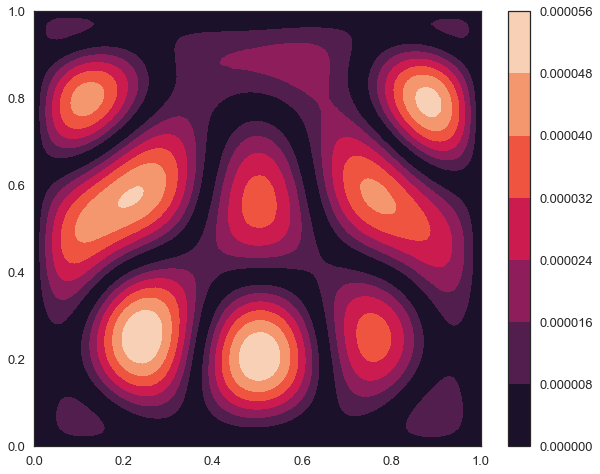

In [17]:
plt.contourf(X1_test, X2_test, diff.data.numpy())
plt.colorbar()